# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

## Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import copy
import random
from collections import deque, namedtuple
from tqdm import trange

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
from platform import python_version
print('Python version :', python_version())
print('PyTorch version:', torch.__version__)

Python version : 3.6.3
PyTorch version: 1.8.1


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'\
      .format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
# play game for 5 episodes
for i in range(1, 6):
    # reset the environment
    env_info = env.reset(train_mode=False)[brain_name]
    # get the current state (for each agent)
    states = env_info.vector_observations
    # initialize the score (for each agent)
    scores = np.zeros(num_agents)
    while True:
        # select an action (for each agent)
        actions = np.random.randn(num_agents, action_size)
        # all actions between -1 and 1
        actions = np.clip(actions, -1, 1)
        # send all actions to tne environment
        env_info = env.step(actions)[brain_name]
        # get next state (for each agent)
        next_states = env_info.vector_observations
        # get reward (for each agent)
        rewards = env_info.rewards
        # see if episode finished
        dones = env_info.local_done
        # update the score (for each agent)
        scores += env_info.rewards
        # roll over states to next time step
        states = next_states
        # exit loop if episode finished
        if np.any(dones):
            break
    print('Score (max over agents) from episode {}: {}'\
          .format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.10000000149011612
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


## Define a neural network architecture

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### Actor (Policy) Model
Maps states to action values. The actor network has the following structure:

* batch normalization for the inputs
* fully connected layer (state size x 128)
* RELU-activation
* fully connected layer (128 x 64)
* RELU-activation
* fully connected layer (64 x action size)

In [7]:
def hidden_init(layer):
    '''Hidden layers initialization'''
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

In [8]:
class Actor(nn.Module):
    
    def __init__(self, state_size, action_size, seed,
                 fc1_units = 128, fc2_units = 64):
        '''
        Neural network parameters:
            state_size (int) : # parameters characterizing the environment state
            action_size (int): # possible actions
            seed (int)       : random seed
            fc1_units (int)  : # nodes in the first hidden layer
            fc2_units (int)  : # nodes in the second hidden layer
        '''
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1  = nn.Linear(state_size, fc1_units)
        self.fc2  = nn.Linear(fc1_units,  fc2_units)
        self.fc3  = nn.Linear(fc2_units,  action_size)

        self.bn1 = nn.BatchNorm1d(state_size)
        
        self.reset_parameters()
    
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = self.bn1(state)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

### Critic (Value) Model
Maps (state, action) pairs to Q-values. The critic network has the following structure:
* batch normalization for the inputs
* fully connected layer (state size x 128)
* RELU-activation
* concatenate the action
* fully connected layer (128 + action size x 64)
* RELU-activation
* fully connected layer (64 x 1)

In [9]:
class Critic(nn.Module):
    def __init__(self, state_size, action_size, seed, 
                 fcs1_units = 128, fc2_units = 64):
        '''
        Neural network parameters:
            state_size (int) : # parameters characterizing the environment state
            action_size (int): # possible actions
            seed (int)       : random seed
            fc1_units (int)  : # nodes in the first hidden layer
            fc2_units (int)  : # nodes in the second hidden layer
        '''
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2  = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn1 = nn.BatchNorm1d(state_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        x  = self.bn1(state)
        xs = F.relu(self.fcs1(x))
        x  = torch.cat((xs, action), dim=1)
        x  = F.relu(self.fc2(x))
        return self.fc3(x)  

## Define the Agent
### Fixed-size buffer to store experience tuples

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
display(device)

device(type='cpu')

In [11]:
class ReplayBuffer:
    '''Fixed-size buffer to store experience tuples'''

    def __init__(self, action_size, buffer_size, batch_size, seed):
        '''Initialize a ReplayBuffer object
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int) : size of each training batch
        '''
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience",
                                     field_names=["state", "action", "reward",
                                                  "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        '''Add a new experience to memory'''
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        '''Randomly sample a batch of experiences from memory'''
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(
            np.vstack([e.state for e in experiences if e is not None]))\
            .float().to(device)
        actions = torch.from_numpy(
            np.vstack([e.action for e in experiences if e is not None]))\
            .float().to(device)
        rewards = torch.from_numpy(
            np.vstack([e.reward for e in experiences if e is not None]))\
            .float().to(device)
        next_states = torch.from_numpy(
            np.vstack([e.next_state for e in experiences if e is not None]))\
            .float().to(device)
        dones = torch.from_numpy(
            np.vstack([e.done for e in experiences if e is not None])\
            .astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        '''Return the current size of internal memory'''
        return len(self.memory)

### Algorithm

The algorithm implementation was adapted from the course repository:

https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-pendulum

Agent parameters:
```
state_size  : environmen state size
action_size : action size
num_agents  : # learning agents
andom_seed  : random seed number (optional)
batch_size  : minibatch size for neural network training
lr_actor    : actor neural network learning rate
lr_critic   : critic neural network learning rate
noise_theta : parameter theta for Ornstein-Uhlenbeck noise process
noise_sigma : parameter sigma for Ornstein-Uhlenbeck noise process
actor_fc1   : # nodes in first hidden layer for actor
actor_fc2   : # nodes in second hidden layer for actor
critic_fc1  : # nodes in first hidden ayer for critic
critic_fc2  : # nodes in second hidden layer for critic
update_every: # time steps between each updating neural networks 
num_updates : # times to update the networks at every update_every interval
buffer_size : buffer size for experience replay
```

In [12]:
WEIGHT_DECAY = 0 # L2 weight decay
class Agent():
    '''Interacts with and learns from the environment'''
    
    def __init__(self, state_size, action_size, num_agents, random_seed = 0,
                 batch_size = 128, lr_actor = 1e-4, lr_critic = 1e-3,
                 noise_theta = 0.15, noise_sigma = 0.2,
                 actor_fc1 = 128, actor_fc2 = 128,
                 critic_fc1 = 128, critic_fc2 = 128,
                 update_every = 1, num_updates = 1, buffer_size = int(2e6)):
        
        '''
            state_size (int) : state size
            action_size (int): action size
            num_agents (int) : number of agents
            random_seed (int): random seed
            batch_size (int) : minibatch size
            lr_actor (float) : the actor network learning rate
            lr_critic (float): the critic network learning rate
            noise_theta (float): theta for Ornstein-Uhlenbeck noise process
            noise_sigma (float): simga for Ornstein-Uhlenbeck noise process
            actor_fc1  = 128   : # nodes in first hidden layer for actor
            actor_fc2  = 128   : # nodes in second hidden layer for actor
            critic_fc1 = 128   : # nodes in first hidden ayer for critic
            critic_fc2 = 128   : # nodes in second hidden layer for critic
            update_every = 1   : # time steps between each
                                 updating neural networks 
            num_updates = 1
            buffer_size = int(2e6): buffer size for experience replay
        '''
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)
        self.batch_size = batch_size
        self.update_every = update_every
        self.num_updates = num_updates
        self.buffer_learn_size = min(batch_size * 10, buffer_size)

        # actor Network (Target Network)
        self.actor_local  = Actor(state_size, action_size, random_seed,
                                  actor_fc1, actor_fc2).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed,
                                  actor_fc1, actor_fc2).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(),
                                          lr=lr_actor)

        # critic Network (Target Network)
        self.critic_local  = Critic(state_size, action_size, random_seed, 
                                    critic_fc1, critic_fc2).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed, 
                                    critic_fc1, critic_fc2).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(),
                                           lr=lr_critic, 
                                           weight_decay=WEIGHT_DECAY)
            
        # noise process
        self.noise = OUNoise((num_agents, action_size), random_seed, 
                             theta=noise_theta, sigma=noise_sigma)

        # replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, 
                                   self.batch_size, random_seed)

        # initialize the time step counter
        # for updating each UPDATE_EVERY number of steps
        self.t_step = 0
    
    def step(self, states, actions, rewards, next_states, 
             dones, gamma = 0.96, tau = 0.001):
        '''Save experience in replay memory, 
        and use random sample from buffer to learn'''
        
        # Save experience / reward
        for state, action, reward, next_state, done in zip(states, actions, 
                                                           rewards, next_states, 
                                                           dones):
            self.memory.add(state, action, reward, next_state, done)

        # Learn every update_every time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory,
            # get a random subset from the
            # saved experiences (weighted if prior_replay = True) and learn
            if len(self.memory) > self.buffer_learn_size:
                for _ in range(self.num_updates):
                    experiences = self.memory.sample()      
                    self.learn(experiences, gamma, tau)

    def act(self, state, add_noise=True, noise_scale=1.0):
        '''Returns actions for given state as per current policy'''
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += (noise_scale * self.noise.sample())
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma, tau):
        '''
        Update policy and value parameters using 
        given batch of experience tuples.
        Q_targets = r + gamma * critic_target(next_state, 
                                              actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]):
            tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        '''
        states, actions, rewards, next_states, dones = experiences

        # ************************* CRITIC UPDATE ************************
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        
        self.critic_optimizer.step()

        # ************************* ACTOR UPDATE *************************
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ********************* TARGET NETWORKS UPDATE *******************
        self.soft_update(self.critic_local, self.critic_target, tau)
        self.soft_update(self.actor_local, self.actor_target, tau)                     

    def soft_update(self, local_model, target_model, tau):
        '''
        Soft update model parameters.
        theta_target = tau*theta_local + (1 - tau)*theta_target
        Weighted average. Smaller tau means more of the updated target model is
        weighted towards the current target model.
            
        local_model : PyTorch model (weights will be copied from)
        target_model: PyTorch model (weights will be copied to)
        tau (float) : interpolation parameter 
        '''
        for target_param, local_param in zip(target_model.parameters(),
                                             local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + 
                                    (1.0-tau)*target_param.data)

### Ornstein-Uhlenbeck process

In [13]:
class OUNoise:

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        '''Initialize parameters and noise process'''
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.size = size
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        '''Reset the internal state (= noise) to mean (mu)'''
        self.state = copy.copy(self.mu)

    def sample(self):
        '''Update internal state and return it as a noise sample'''
        x = self.state
        dx = (self.theta * (self.mu - x) + 
              self.sigma * np.random.standard_normal(self.size))

        self.state = x + dx
        return self.state

## DDPG (Deep Deterministic Policy Gradients)

Loop through each episode:
```
- get an action
- send the action to the environment
- get the next state
- get the reward
- add the state, action, reward, and next state to the experience replay buffer
- every # time steps in the environment,
  randomly sample the experience replay buffer and perform # learning steps
- updating the critic network for each learning step
- updating the actor network for each learning step
- add the reward to the score
- update the state to the next state and loop back to step 1
```

In [14]:
def ddpg(agent, prefix, n_episodes=2000, max_t=1500, 
         gamma_initial = 0.9, gamma_final = 0.99, gamma_rate = 0.002,
         tau_initial = 0.02, tau_final = 0.001, tau_rate = 0.001,
         noise_factor = 1.0):
    '''
    Deep Deterministic Policy Gradients
    
    PARAMETERS:
    agent (object)       : the learning agent
    prefix (string)      : a prefix string for naming all of the checkpoints
                           of the actor and critic neural networks that are saved
    n_episodes (int)     : maximum number of training episodes
    max_t (int)          : maximum number of timesteps per episode
    gamma_initial (float): initial gamma discount factor (0 to 1);
                              higher values favor long term over current rewards
    gamma_final (float)  : final gamma discount factor (0 to 1)
    gammma_rate (float)  : a rate (0 to 1) for increasing gamma
    tau_initial (float)  : initial value for tau, the weighting factor
                              for soft updating the neural networks
    tau_final (float)    : final value of tau
    tau_rate (float)     : rate (0 to 1) for increasing tau each episode
    noise_factor         : the value for scaling the noise
                           every episode to gradually decrease it
    '''
    
    gamma = gamma_initial
    gamma_scale = 1.0 - gamma_rate
    
    tau = tau_initial
    tau_scale = 1.0 - tau_rate
    
    noise_scale = 1.0
    scores_deque = deque(maxlen=100)
    scores, avg_max_scores = [], []
    for i_episode in trange(1, n_episodes+1):
        
        # Reset environment
        env_info = env.reset(train_mode=True)[brain_name]
        
        # Get next state
        state = env_info.vector_observations
        
        # state = env.reset()
        agent.reset()

        score = np.zeros(agent.num_agents)
        
        for t in range(max_t):
            
            # get action
            action = agent.act(state, noise_scale)
            # send action to environment
            env_info = env.step(action)[brain_name]
            # get next state
            next_state = env_info.vector_observations
            # get reward
            reward = env_info.rewards
            
            # check if episode is finished
            done = env_info.local_done
            
            agent.step(state, action, reward, next_state, done, gamma, tau)
            score += reward  # update the score
            state = next_state
            
            if np.any(done):
                break # exit if episode is finished
                
        agent_max_score = np.max(score)
        scores.append(agent_max_score)
        scores_deque.append(agent_max_score)
        avg_max_scores.append(np.mean(scores_deque))
                
        # Increase gamma discount factor. Limit to gamma_final.
        gamma = gamma_final - gamma_scale * (gamma_final - gamma)
        
        tau = tau_final - tau_scale * (tau_final - tau)
        
        noise_scale *= noise_factor
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.5f}'.\
                format(i_episode, np.mean(scores_deque)))

    # saved Model Weights
    torch.save(agent.actor_local.state_dict() , prefix + '_actor.pth')
    torch.save(agent.critic_local.state_dict(), prefix + '_critic.pth')
    return scores, avg_max_scores

## Train the Agent

In [15]:
agent = Agent(state_size = state_size, action_size = action_size,
              num_agents = num_agents, random_seed = 0, batch_size = 1024, 
              lr_actor = 0.001, lr_critic = 0.001,
              noise_theta = 0.2, noise_sigma = 0.1, # noise_theta = 0.1, noise_sigma = 0.04
              actor_fc1 = 128, actor_fc2 = 128,
              critic_fc1 = 128, critic_fc2 = 128,
              update_every = 20, num_updates = 5, buffer_size = int(2e6))

### Learning parameters:
```
agent        : the agent
prefix       : a prefix string for naming all of the checkpoints
n_episodes   : maximum number of training episodes
max_t        : maximum number of timesteps per episode
gamma_initial: initial gamma discount factor (0 to 1)
gamma_final  : final gamma discount factor (0 to 1)
gammma_rate  : a rate (0 to 1) for increasing gamma
tau_initial  : initial value for tau, the weighting factor
               for soft updating the neural networks
tau_final    : final value of tau
tau_rate     : rate (0 to 1) for increasing tau each episode
noise_factor : the value for scaling the noise (<=1)
```

In [16]:
scores = ddpg(agent,
              prefix = 'tennis',
              n_episodes = 2000,
              max_t = 10000,
              gamma_initial = 0.95,
              gamma_final = 0.99,
              gamma_rate = 0.01,
              tau_initial = 0.01,
              tau_final = 0.001,
              tau_rate = 0.001,
              noise_factor = 0.9999)

  5%|▌         | 104/2000 [00:05<01:33, 20.36it/s]

Episode 100	Average Score: 0.01000


 10%|█         | 206/2000 [00:08<00:56, 31.67it/s]

Episode 200	Average Score: 0.00300


 15%|█▌        | 305/2000 [00:12<00:56, 29.75it/s]

Episode 300	Average Score: 0.00490


 20%|██        | 401/2000 [00:26<04:35,  5.80it/s]

Episode 400	Average Score: 0.00800


 25%|██▌       | 502/2000 [00:41<03:06,  8.02it/s]

Episode 500	Average Score: 0.00100


 30%|███       | 600/2000 [00:56<03:49,  6.11it/s]

Episode 600	Average Score: 0.00590


 35%|███▌      | 701/2000 [01:18<03:32,  6.12it/s]

Episode 700	Average Score: 0.03190


 40%|████      | 800/2000 [01:45<28:01,  1.40s/it]

Episode 800	Average Score: 0.04240


 45%|████▌     | 900/2000 [03:00<07:28,  2.46it/s]

Episode 900	Average Score: 0.16370


 50%|█████     | 1000/2000 [05:13<07:19,  2.28it/s] 

Episode 1000	Average Score: 0.30680


 55%|█████▌    | 1100/2000 [06:04<09:18,  1.61it/s]

Episode 1100	Average Score: 0.12300


 60%|██████    | 1200/2000 [08:41<1:04:07,  4.81s/it]

Episode 1200	Average Score: 0.36150


 65%|██████▌   | 1300/2000 [17:10<30:40,  2.63s/it]  

Episode 1300	Average Score: 1.16140


 70%|███████   | 1400/2000 [29:22<1:04:59,  6.50s/it]

Episode 1400	Average Score: 1.22040


 75%|███████▌  | 1500/2000 [48:00<2:02:15, 14.67s/it]

Episode 1500	Average Score: 1.68640


 80%|████████  | 1600/2000 [1:12:11<1:22:48, 12.42s/it]

Episode 1600	Average Score: 1.87500


 85%|████████▌ | 1700/2000 [1:32:40<51:04, 10.21s/it]  

Episode 1700	Average Score: 1.57160


 90%|█████████ | 1800/2000 [1:57:01<34:26, 10.33s/it]  

Episode 1800	Average Score: 1.54310


 95%|█████████▌| 1900/2000 [2:21:27<35:45, 21.45s/it]  

Episode 1900	Average Score: 1.39640


100%|██████████| 2000/2000 [2:46:36<00:00,  5.00s/it]

Episode 2000	Average Score: 1.37800


### Plot of Rewards
The agent receives an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents).

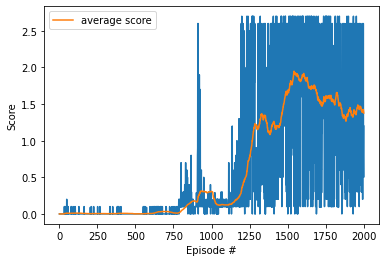

In [17]:
# conda upgrade matplotlib
# pip install --upgrade matplotlib
# conda install matplotlib=2 # downgraded matplotlib to version 2
# WARNING:matplotlib:Bad key text.latex.unicode
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores[0])+1), scores[0])
plt.plot(np.arange(1, len(scores[1])+1), scores[1], label='average score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

When finished, you can close the environment.

In [19]:
env.close()

## Ideas for Future Work
* Optimization of the existing code
* Search for optimal hyperparameters (it is necessary to pay special attention to the values of theta and sigma, which maybe have a significant impact on the learning process)
* Implementation of the other algorithms such as PPO, A3C and D4PG